<a href="https://colab.research.google.com/github/AugustinCablant/Stat-App/blob/main/MH_GIBBS_simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install POT
#!pip install matplotlib
import ot
import numpy as np
import matplotlib.pyplot as plt

n = 10**4
sigma=0.04  #on utilise celui du papier 
np.random.seed(123)

def proba_rejet(u,v,W,x,y,Z,T):
    u,v,W=histogramme(u),histogramme(v),histogramme(W)
    x,y,Z=histogramme(x),histogramme(y),histogramme(Z)
    return 1/(2*sigma**2)*(np.linalg.norm(T-ot.emd(u,v,W))**2-np.linalg.norm(T-ot.emd(x,y,Z))**2)

def in_hypercube(u, v, W):
    # Vérifie si au moins un élément de la liste u est en dehors de l'intervalle [0, 1]
    if any(x < 0 or x > 1 for x in u) or any(x < 0 or x > 1 for x in v):
        return False  
    # Vérifie si au moins un élément de chaque sous-liste de la liste W est en dehors de l'intervalle [0, 1]
    if any(any(x < 0 or x > 1 for x in row) for row in W):
        return False  
    return True 


def histogramme(x):
    # Normaliser la liste pour que la somme soit égale à 1
    somme = np.sum(x)
    histogramme = x / somme
    return histogramme

def MH_gibbs(T):
    """  Algorithme de Gibbs 
    Parametres
    ----------
    T : np.array
        Matrice de transport dont l'on souhaite estimer les coûts 
    
    Returns
    ----------
    U, V : np.array
        Vecteurs U et V 
    C : np.array
        Matrice estimées des coûts
    acceptance_rate_x : float
        Taux d'acceptation de x
    running_average_x : float 
        Running average de x
    """

    N = len(T)  #taille des vecteurs 
    # Initialisation
    U, V, C = np.zeros((n, N)), np.zeros((n, N)), np.zeros((n, N, N))
    U[0] = np.random.uniform(size=N)
    V[0] = np.random.uniform(size=N)
    C[0, :, :] = np.random.uniform(size=(N, N))

    def fix_coord(x):
        """ Permet de fixer la diagonale à 10
        """
        for i in range(N): x[i,i]=10
        return x
    # Vecteurs aléatoires
    e_u, e_v,e_C  = np.random.normal(0, 0.01, (N, n)), np.random.normal(0, 0.01, (N, n)), np.random.normal(0, 0.01, (N, N, n))
    u_u, u_v, u_c  = np.log(np.random.uniform(size=n)), np.log(np.random.uniform(size=n)), np.log(np.random.uniform(size=n))

    acceptance_rate_u, acceptance_rate_v,  acceptance_rate_C = 0, 0, 0
    running_average_U,  running_average_V, running_average_C = [U[0]], [V[0]], [C[0]]

    for k in range(n-1):  #rappel: n est la longueur de la chaîne
        #on procède composante par composante

        # Pas pour U
        x, y, Z = U[k] + e_u[:, k], V[k], C[k]
        if not in_hypercube(x, y, Z): U[k+1], V[k+1], C[k+1] = U[k], V[k], C[k]  #la chaîne n'évolue pas
        else:
            if u_u[k] < proba_rejet(U[k], V[k], C[k], x, y, Z,T):
                U[k+1], V[k+1], C[k+1] = x, y, Z  #la chaîne évolue en la composante U
                acceptance_rate_u += 1  #ici acceptation de la proposition
            else: U[k+1], V[k+1], C[k+1] = U[k], V[k], C[k]
        UK=U[k+1]  #conserver la nouvelle valeur de U afin de l'utiliser pour V et C
        #même schéma pour les composantes V et C
        # Pas pour V
        x, y, Z = UK, V[k] + e_v[:, k], C[k]
        if not in_hypercube(x, y, Z): U[k+1], V[k+1], C[k+1] = UK, V[k], C[k]
        else:
            if u_v[k] < proba_rejet(UK, V[k], C[k], x, y, Z,T):
                U[k+1], V[k+1], C[k+1] = x, y, Z
                acceptance_rate_v += 1
            else: U[k+1], V[k+1], C[k+1] = UK, V[k], C[k]
        VK=V[k+1]
        # Pas pour C
        x, y, Z = UK, VK, C[k] + e_C[:, :, k]
        if not in_hypercube(x, y, Z):
            U[k+1], V[k+1], C[k+1] = UK, VK, C[k]
        else:
            if u_c[k] < proba_rejet(U[k], V[k], C[k], x, y, Z,T):
                U[k+1], V[k+1], C[k+1] = x, y, Z
                acceptance_rate_C += 1
            else: U[k+1], V[k+1], C[k+1] = UK, VK, C[k]

        # Calcul du running average
        running_average_U.append((U[k+1]+U[k])*(k/(k+1)))
        running_average_V.append((V[k+1]+V[k])*(k/(k+1)))
        running_average_C.append((C[k+1]+C[k])*(k/(k+1)))

    acceptance_rate_u /= n
    acceptance_rate_v /= n
    acceptance_rate_C /= n
    return U, V, C, acceptance_rate_u,acceptance_rate_v,acceptance_rate_C, running_average_U,running_average_V,running_average_C

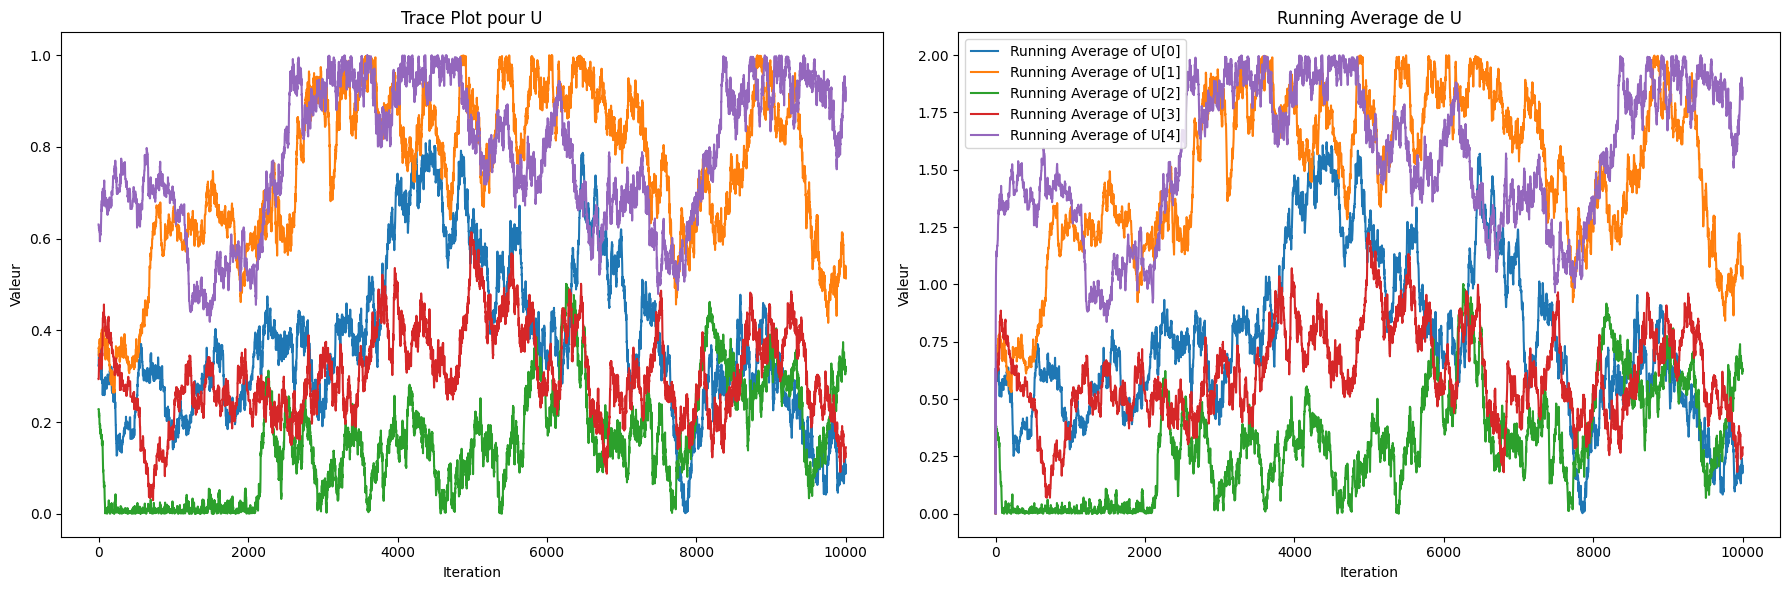

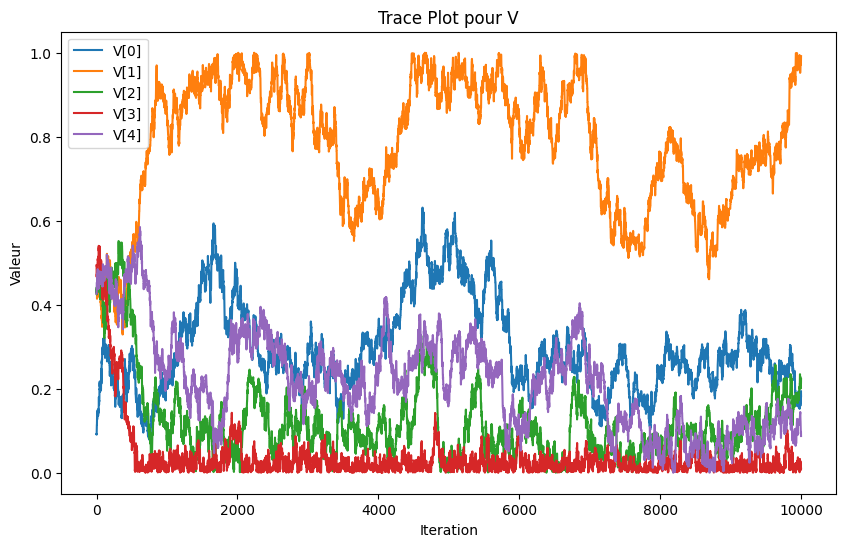

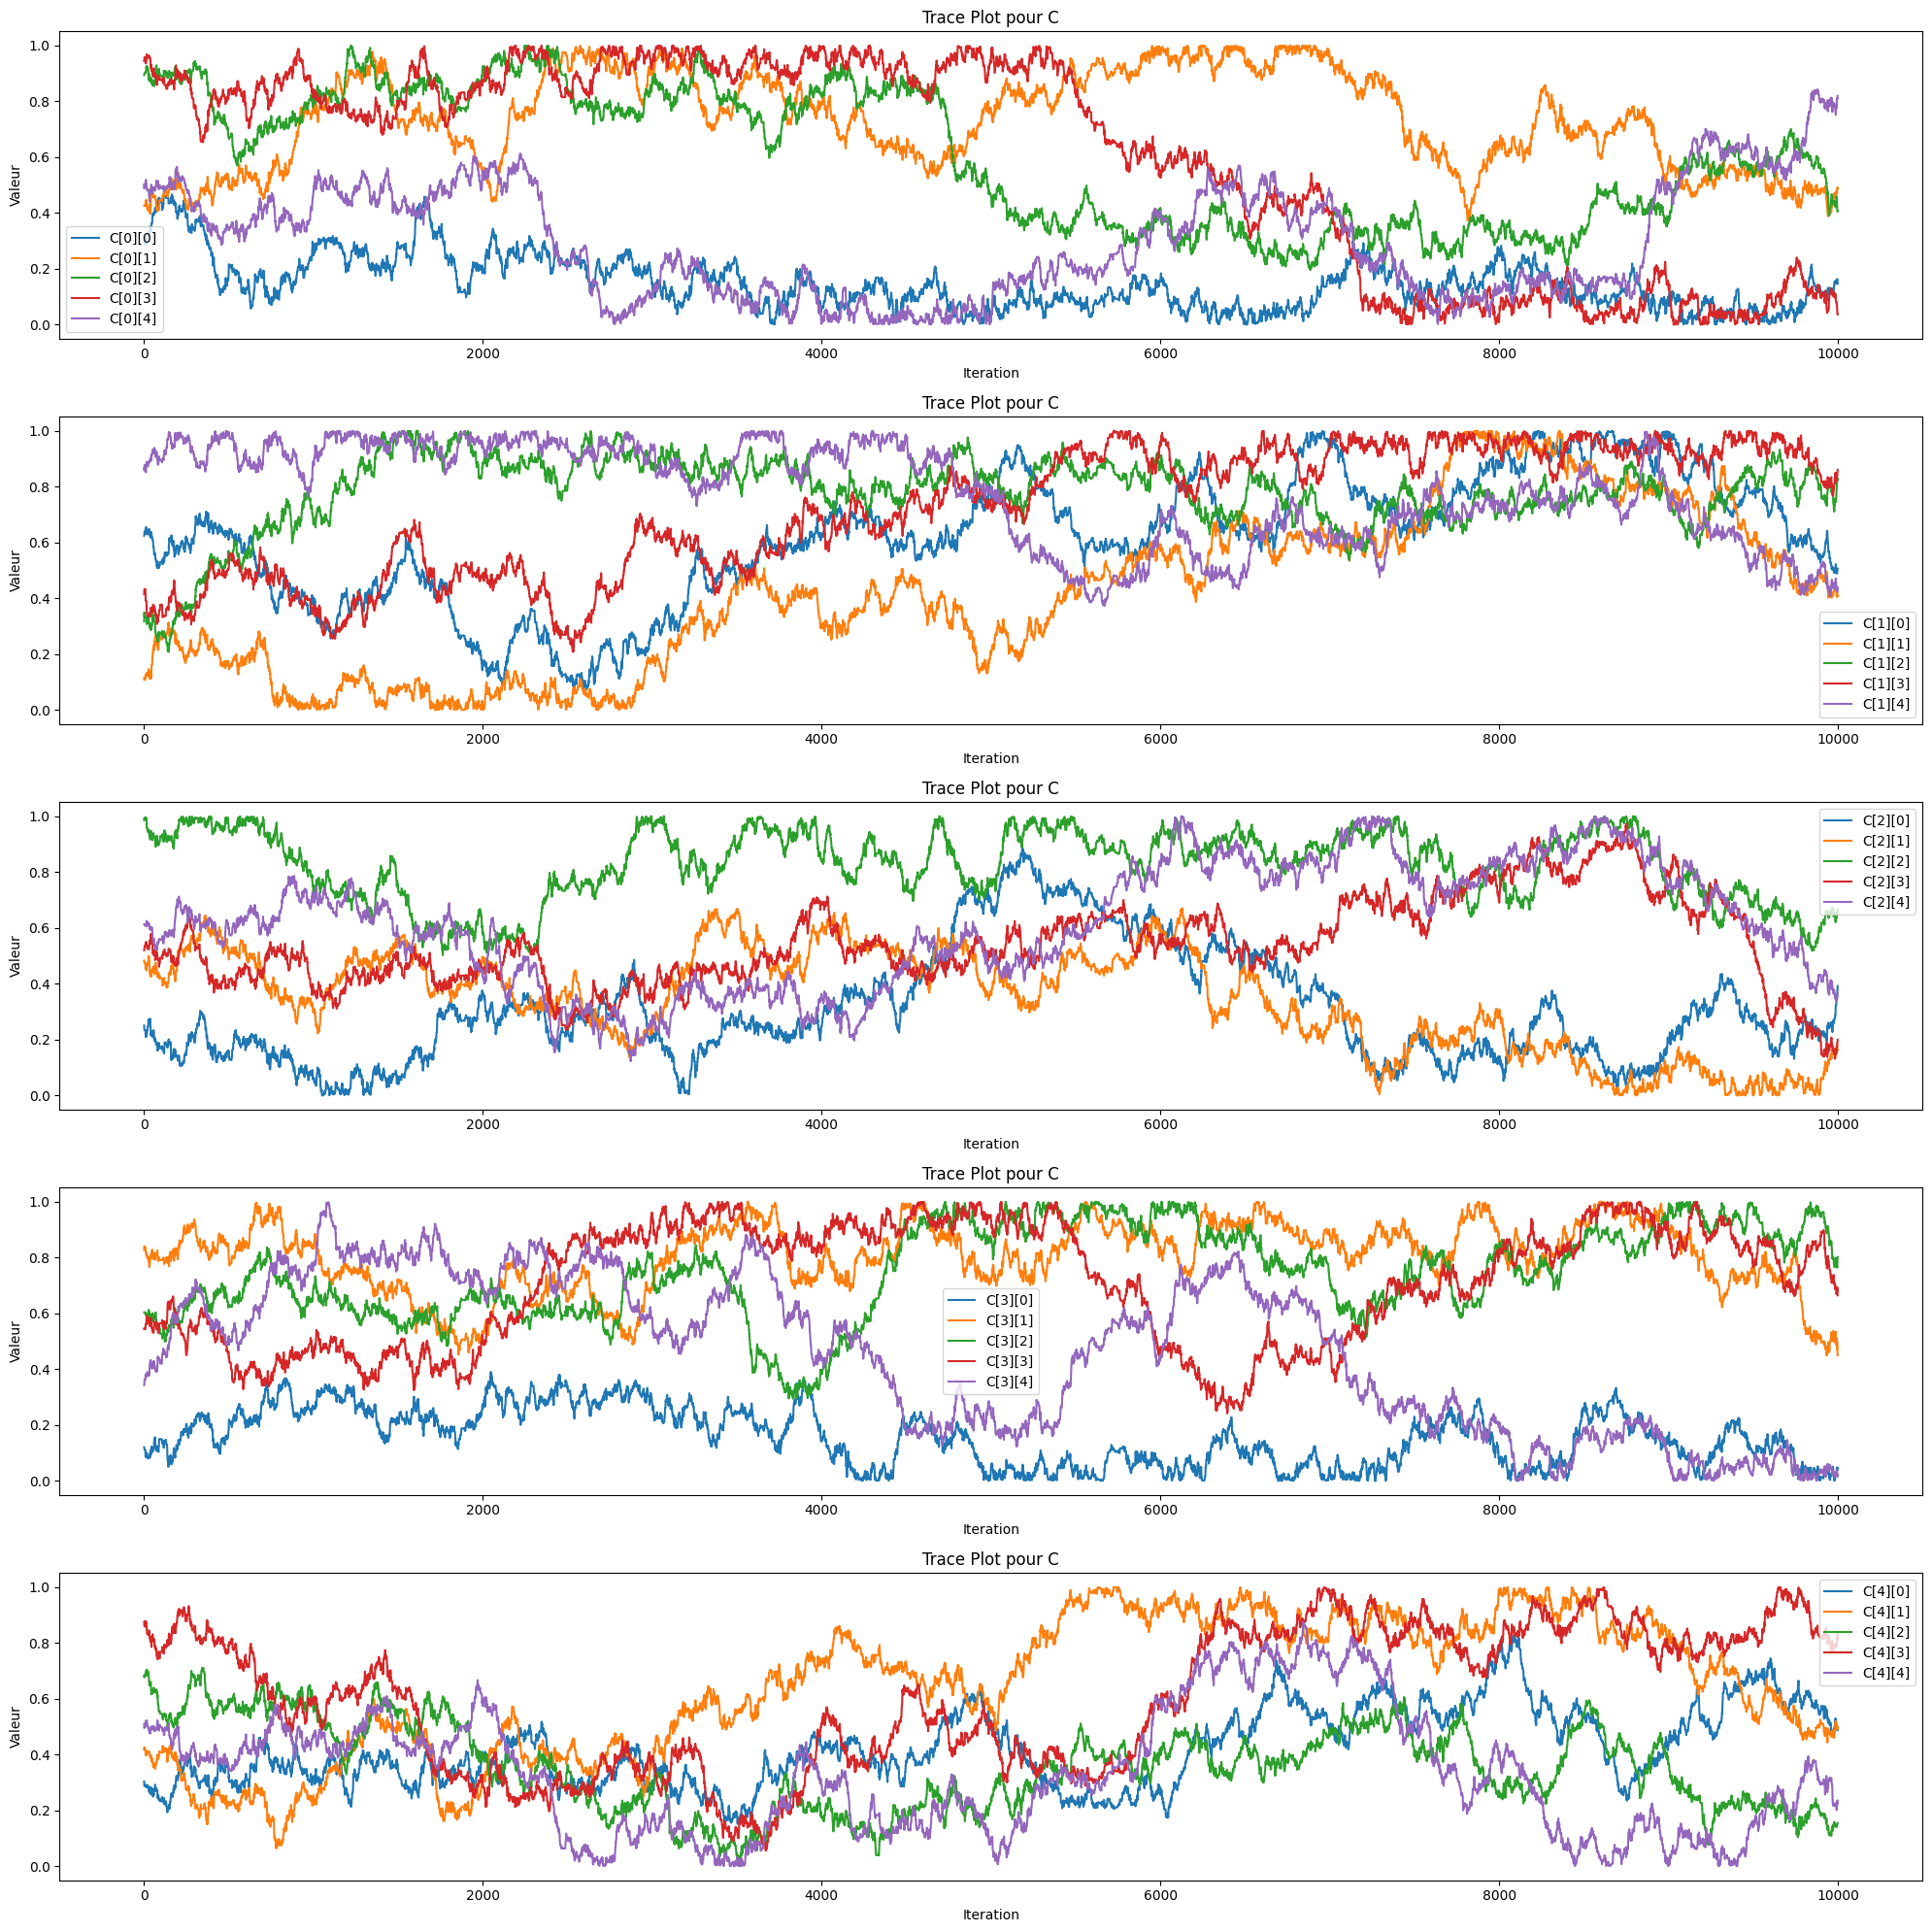

Taux d'acceptation pour U : 0.7803
Taux d'acceptation pour V : 0.6726
Taux d'acceptation pour C : 0.6382


In [26]:
#Simulation test pour une matrice 5x5
np.random.seed(123)
T = np.random.uniform(size=(5, 5))  #matrice aléatoire

# Simulation
U, V, C, acceptance_rate_u,acceptance_rate_v,acceptance_rate_C, running_average_U,running_average_V,running_average_C = MH_gibbs(T)

plt.figure(figsize=(18, 6))
# Trace plot pour U
plt.subplot(1, 2, 1)
for i in range(len(U[0])):
    plt.plot(U[:, i], label=f"U[{i}]")
plt.title("Trace Plot pour U")
plt.xlabel("Iteration")
plt.ylabel("Valeur")

#Running average de U
plt.subplot(1, 2, 2)
for i in range(len(U[0])):
    plt.plot(list(range(len(running_average_U))), [sample[i] for sample in running_average_U], label=f'Running Average of U[{i}]')
plt.title("Running Average de U")
plt.xlabel("Iteration")
plt.ylabel("Valeur")
plt.legend()
plt.tight_layout() 
plt.show()

# Trace plot pour V
plt.figure(figsize=(10, 6))
for i in range(len(U[0])):
    plt.plot(V[:, i], label=f"V[{i}]")
plt.title("Trace Plot pour V")
plt.xlabel("Iteration")
plt.ylabel("Valeur")
plt.legend()
plt.show()


plt.figure(figsize=(20, 20))
for i in range(len(C[0])):
    plt.subplot(len(C[0]), 1, i + 1)
    for j in range(len(C[1])):
        plt.plot(C[:, i, j], label=f"C[{i}][{j}]")
    plt.title("Trace Plot pour C")
    plt.xlabel("Iteration")
    plt.ylabel("Valeur")
    plt.legend()
plt.tight_layout() 
plt.show()

print(f"Taux d'acceptation pour U : {acceptance_rate_u}")
print(f"Taux d'acceptation pour V : {acceptance_rate_v}")
print(f"Taux d'acceptation pour C : {acceptance_rate_C}")